<a href="https://colab.research.google.com/github/lukas-plojhar/OnlineRetailDataset/blob/main/Online_Retail_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import re
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn import preprocessing, cluster

sns.set_theme(style='whitegrid')

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

df=pd.read_excel('/content/drive/My Drive/Online Retail.xlsx')
df=df.rename(columns={
    'InvoiceNo':'invoice_no',
    'StockCode':'stockcode',
    'Description':'description',
    'Quantity':'quantity',
    'InvoiceDate':'invoice_date',
    'UnitPrice':'unit_price',
    'CustomerID':'customer_id',
    'Country':'country',
})

Mounted at /content/drive



**InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

**StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

**Description**: Product (item) name. Nominal.

**Quantity**: The quantities of each product (item) per transaction. Numeric.

**InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated.

**UnitPrice**: Unit price. Numeric, Product price per unit in sterling.
CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

**Country**: Country name. Nominal, the name of the country where each customer resides

# **Missing values**

Inspect data file and check for missing values

In [ ]:
print(f'{df.info()}\n\n')
print(f'{df.describe().round(2)}\n\n')
print(f'{df.isnull().sum()}\n')
print(f'--------------------------\n')
for col in df.columns:
  total=len(df[col])
  err=df.isnull().sum()[col]
  if err>0:
    print(f'{col} is missing {round(err/total*100, 2)}% values, total of {err}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    541909 non-null  object        
 1   stockcode     541909 non-null  object        
 2   description   540455 non-null  object        
 3   quantity      541909 non-null  int64         
 4   invoice_date  541909 non-null  datetime64[ns]
 5   unit_price    541909 non-null  float64       
 6   customer_id   406829 non-null  float64       
 7   country       541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


        quantity  unit_price  customer_id
count  541909.00   541909.00    406829.00
mean        9.55        4.61     15287.69
std       218.08       96.76      1713.60
min    -80995.00   -11062.06     12346.00
25%         1.00        1.25     13953.00
50%         3.00        2.08     15152.

**Description**

After analyzing rows with missing description we see other columns are also missing values, such as customer_id and/or unit_price.

We can drop these rows.

In [ ]:
print(f'{df[df.description.isnull()].describe()}\n')
print(f'Unique values for customer_id: {df[(df.isnull().description)].customer_id.unique()}')
print(f'Unique values for unit_price: {df[(df.isnull().description)].unit_price.unique()}\n')

df.dropna(subset=['description'], inplace=True)

print(df.shape[0])
df.isnull().sum()

       quantity  unit_price  ...  stockcode_chars  stockcode_chars_ratio
count       0.0         0.0  ...              0.0                    0.0
mean        NaN         NaN  ...              NaN                    NaN
std         NaN         NaN  ...              NaN                    NaN
min         NaN         NaN  ...              NaN                    NaN
25%         NaN         NaN  ...              NaN                    NaN
50%         NaN         NaN  ...              NaN                    NaN
75%         NaN         NaN  ...              NaN                    NaN
max         NaN         NaN  ...              NaN                    NaN

[8 rows x 6 columns]

Unique values for customer_id: []
Unique values for unit_price: []

537228


invoice_no                    0
stockcode                     0
description                   0
quantity                      0
invoice_date                  0
unit_price                    0
customer_id              132481
country                       0
stockcode_length              0
stockcode_chars               0
stockcode_chars_ratio         0
dtype: int64

**Stockcode**

There is inconsistency in sample stockcodes based on the domain knowledge. 

*StockCode: Product (item) code. Nominal, a **5-digit integral number** uniquely assigned to each distinct product.*

In [ ]:
def count_chars(x):
  return len(re.findall('[a-z]', x.lower()))

df['stockcode_length'] = df.stockcode.apply(lambda x: len(str(x)))
df['stockcode_chars'] = df.stockcode.apply(lambda x: count_chars(str(x)))
df['stockcode_chars_ratio'] = df['stockcode_chars'] / df['stockcode_length']

# Stockcodes with 3+ characters
tmp=df[df.stockcode_chars > 2].stockcode.unique()
print(tmp)

# df[df['stockcode'].isin(tmp)].groupby('stockcode').invoice_no.nunique().reset_index()
print(df[df['stockcode'].isin(tmp)].describe())

# Stockcodes with only characters
df[df.stockcode_chars_ratio == 1].head(20)

['POST' 'DOT' 'BANK CHARGES' 'AMAZONFEE' 'DCGS0076' 'DCGS0003'
 'gift_0001_40' 'DCGS0070' 'gift_0001_50' 'gift_0001_30' 'gift_0001_20'
 'DCGS0069' 'DCGSSBOY' 'DCGSSGIRL' 'gift_0001_10' 'PADS' 'DCGS0004'
 'DCGS0073' 'DCGS0068' 'DCGS0067' 'CRUK']
          quantity    unit_price  ...  stockcode_chars  stockcode_chars_ratio
count  2122.000000   2122.000000  ...      2122.000000            2122.000000
mean      1.774270    244.083560  ...         3.919416               0.985195
std       2.127576   1127.588588  ...         1.348899               0.090870
min     -11.000000      0.000000  ...         3.000000               0.333333
25%       1.000000     18.000000  ...         3.000000               1.000000
50%       1.000000     19.875000  ...         4.000000               1.000000
75%       2.000000    153.867500  ...         4.000000               1.000000
max      21.000000  17836.460000  ...        11.000000               1.000000

[8 rows x 6 columns]


,invoice_no,stockcode,description,quantity,invoice_date,unit_price,customer_id,country,stockcode_length,stockcode_chars,stockcode_chars_ratio
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583.0,France,4,4,1.0
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,1,1,1.0
386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.00,12791.0,Netherlands,4,4,1.0
1123,536527,POST,POSTAGE,1,2010-12-01 13:04:00,18.00,12662.0,Germany,4,4,1.0
1814,536544,DOT,DOTCOM POSTAGE,1,2010-12-01 14:32:00,569.77,NaN,United Kingdom,3,3,1.0
2239,536569,M,Manual,1,2010-12-01 15:35:00,1.25,16274.0,United Kingdom,1,1,1.0
2250,536569,M,Manual,1,2010-12-01 15:35:00,18.95,16274.0,United Kingdom,1,1,1.0
3041,536592,DOT,DOTCOM POSTAGE,1,2010-12-01 17:06:00,607.49,NaN,United Kingdom,3,3,1.0
5073,536840,POST,POSTAGE,1,2010-12-02 18:27:00,18.00,12738.0,Germany,4,4,1.0
5258,536852,POST,POSTAGE,1,2010-12-03 09:51:00,18.00,12686.0,France,4,4,1.0


In [ ]:
# Stockcodes with less than 5 characters
print(df[df.stockcode_length<5].stockcode.unique())
df[df.stockcode_length<5].head(20)

[]


,invoice_no,stockcode,description,quantity,invoice_date,unit_price,customer_id,country,stockcode_length,stockcode_chars,stockcode_chars_ratio,is_cancel,invoice_no_length,invoice_no_chars


Some stockcodes are postage, bank and other fees. Also free gifts or other unidentified items. Furthermore, these rows have multiple unit prices with high variation while quantity is low or negative.

We drop these rows as they are not relevant for further analysis and might bias other data.

In [ ]:
df.drop(df[df.stockcode_chars > 1].index, inplace=True)
df.drop(df[df.stockcode_chars_ratio == 1].index, inplace=True)
df.drop(df[df.stockcode_length < 5].index, inplace=True)
df.drop(columns=['stockcode_length', 'stockcode_chars', 'stockcode_chars_ratio'])
print(df.shape[0])

537085


**Invoice**

Split invoices based on cancellations and look for inconsistency with domain knowledge.

In [ ]:
def count_chars(x):
  return len(re.findall('[a-z]', x.lower()))

df['is_cancel'] = df.invoice_no.apply(lambda x: str(x).startswith('C'))
df['invoice_no_length'] = df.invoice_no.apply(lambda x: len(str(x)))
df['invoice_no_chars'] = df.invoice_no.apply(lambda x: count_chars(str(x)))

# Check possible invoice length
print(f'Invoice_no length: {df.invoice_no_length.unique()}')
print(f'Invoice_no chars: {df.invoice_no_chars.unique()}\n')

# Check for invoices with more than 6 symbols that are not cancellations
df[(df.invoice_no_length > 6) & ~df.is_cancel].head()

Invoice_no length: [6 7]
Invoice_no chars: [0 1]



,invoice_no,stockcode,description,quantity,invoice_date,unit_price,customer_id,country,stockcode_length,stockcode_chars,stockcode_chars_ratio,is_cancel,invoice_no_length,invoice_no_chars


There are additinal rows outside orders and cancellations.

It's mostly description of events, it is not relevant and can be dropped.

In [ ]:
df[df.is_cancel].describe()

# Check for invalid invoice quantity. All invoices with negative quantity have no unit_price. Cancellations have positive values.
print(df[(df.quantity < 0) & ~df.is_cancel].describe())
print(df[(df.quantity < 0) & ~df.is_cancel].description.unique())
df[(df.quantity < 0) & ~df.is_cancel].head()

# Drop temporary columns
df.drop(df[(df.quantity < 0) & ~df.is_cancel].index, inplace=True)
df.drop(columns=['is_cancel', 'invoice_no_length', 'invoice_no_chars'])

       quantity  unit_price  ...  invoice_no_length  invoice_no_chars
count       0.0         0.0  ...                0.0               0.0
mean        NaN         NaN  ...                NaN               NaN
std         NaN         NaN  ...                NaN               NaN
min         NaN         NaN  ...                NaN               NaN
25%         NaN         NaN  ...                NaN               NaN
50%         NaN         NaN  ...                NaN               NaN
75%         NaN         NaN  ...                NaN               NaN
max         NaN         NaN  ...                NaN               NaN

[8 rows x 8 columns]
[]


,invoice_no,stockcode,description,quantity,invoice_date,unit_price,customer_id,country,stockcode_length,stockcode_chars,stockcode_chars_ratio
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,6,1,0.166667
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,5,0,0.000000
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,6,1,0.166667
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,6,1,0.166667
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,6,1,0.166667
...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,5,0,0.000000
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,5,0,0.000000
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,5,0,0.000000
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,5,0,0.000000


**Customer ID**

Even though some rows are having missing customer_id other data seems complete. We do not drop these rows. 

In [ ]:
df_inv = df[df.isnull().customer_id]
from_date = df_inv.invoice_date.min()
to_date = df_inv.invoice_date.max()

print(f'period\t\t{from_date} - {to_date}')
print(f'total orders\t{df[(df.invoice_date > from_date) & (df.invoice_date < to_date)].invoice_no.nunique()}')
print(f'invalid orders\t{df_inv.invoice_no.nunique()}\n\n')

# Describe rows with missing customer_id
df[df.customer_id.isnull()].describe()

df[df.customer_id.isnull() & (df.quantity < 0)].head()

# Drop invalid missing customer_id
# df.dropna(subset=['customer_id'], inplace=True)
df.isnull().sum()

period		2010-12-01 14:32:00 - 2011-12-09 10:26:00
total orders	23259
invalid orders	1587




,invoice_no,stockcode,description,quantity,invoice_date,unit_price,customer_id,country,stockcode_length,stockcode_chars,stockcode_chars_ratio,is_cancel,invoice_no_length,invoice_no_chars
11502,C537251,22429,ENAMEL MEASURING JUG CREAM,-2,2010-12-06 10:45:00,4.25,NaN,United Kingdom,5,0,0.0,True,7,1
11503,C537251,22620,4 TRADITIONAL SPINNING TOPS,-8,2010-12-06 10:45:00,1.25,NaN,United Kingdom,5,0,0.0,True,7,1
11504,C537251,21890,S/6 WOODEN SKITTLES IN COTTON BAG,-2,2010-12-06 10:45:00,2.95,NaN,United Kingdom,5,0,0.0,True,7,1
11505,C537251,22564,ALPHABET STENCIL CRAFT,-5,2010-12-06 10:45:00,1.25,NaN,United Kingdom,5,0,0.0,True,7,1
11506,C537251,21891,TRADITIONAL WOODEN SKIPPING ROPE,-3,2010-12-06 10:45:00,1.25,NaN,United Kingdom,5,0,0.0,True,7,1


# **Feature engineering**

Split invoice_date into separate features and reorganize the columns of the dataframe.

In [ ]:
df['total_price'] = df.unit_price * df.quantity
df['invoice_date_year'] = df['invoice_date'].dt.year
df['invoice_date_month'] = df['invoice_date'].dt.month
df['invoice_date_day'] = df['invoice_date'].dt.day
df['invoice_date_hour'] = df['invoice_date'].dt.hour
df['invoice_date_weekday'] = df['invoice_date'].dt.weekday
df['is_cancel'] = df.invoice_no.apply(lambda x: str(x).startswith('C'))

df = df[['customer_id','invoice_no','is_cancel','stockcode','unit_price','quantity','total_price','country','invoice_date_year','invoice_date_month','invoice_date_day','invoice_date_hour','invoice_date_weekday','invoice_date']]

df.head()


,customer_id,invoice_no,is_cancel,stockcode,unit_price,quantity,total_price,country,invoice_date_year,invoice_date_month,invoice_date_day,invoice_date_hour,invoice_date_weekday,invoice_date
0,17850.0,536365,False,85123A,2.55,6,15.30,United Kingdom,2010,12,1,8,2,2010-12-01 08:26:00
1,17850.0,536365,False,71053,3.39,6,20.34,United Kingdom,2010,12,1,8,2,2010-12-01 08:26:00
2,17850.0,536365,False,84406B,2.75,8,22.00,United Kingdom,2010,12,1,8,2,2010-12-01 08:26:00
3,17850.0,536365,False,84029G,3.39,6,20.34,United Kingdom,2010,12,1,8,2,2010-12-01 08:26:00
4,17850.0,536365,False,84029E,3.39,6,20.34,United Kingdom,2010,12,1,8,2,2010-12-01 08:26:00


**Cancelled orders**

Group rows by invoice_no - individual orders

In [ ]:
df_can = df[df.is_cancel].groupby('invoice_no', as_index=False).agg({
    'customer_id': lambda x: x.unique(),
    'total_price': 'sum',
    'quantity': ['sum', 'nunique'],
    'country': lambda x: x.unique()[0],
})

df_can.columns = ['invoice_no', 'customer_id','total_revenue', 'total_items', 'unique_items','country']

In [ ]:
df_can_customers = pd.DataFrame(df_can.groupby('customer_id').invoice_no.nunique().sort_values(ascending=False)).reset_index()
df_can_customers.columns = ['customer_id', 'cancellations']
df_can_customers

# orders_total = df.invoice_no.nunique()
# cancellations_total = df_can_customers.cancellations.sum()
# customers_total = df.customer_id.nunique()
# can_customers_total = df_can_customers.shape[0]

# Customers who return the most orders
def get_orders(x):
  return df[df.customer_id == x].invoice_no.nunique()

df_can_customers.drop(df_can_customers[df_can_customers.cancellations < 5].index, inplace=True)
df_can_customers['orders'] = df_can_customers.customer_id.apply(lambda x: get_orders(x))
df_can_customers['return_ratio'] = round(df_can_customers.cancellations / df_can_customers.orders, 2)
df_can_customers.sort_values(by='return_ratio', ascending = False, inplace=True)
df_can_customers

,customer_id,cancellations,orders,return_ratio
28,13115.0,10,14,0.71
88,14441.0,6,10,0.60
116,12679.0,5,9,0.56
101,17204.0,5,9,0.56
82,13136.0,6,11,0.55
...,...,...,...,...
119,15039.0,5,52,0.10
121,17949.0,5,49,0.10
125,16013.0,5,52,0.10
66,13798.0,6,63,0.10


**Best-selling Products**

Identify best selling products based on unique orders

Identify product distribution in unique orders

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


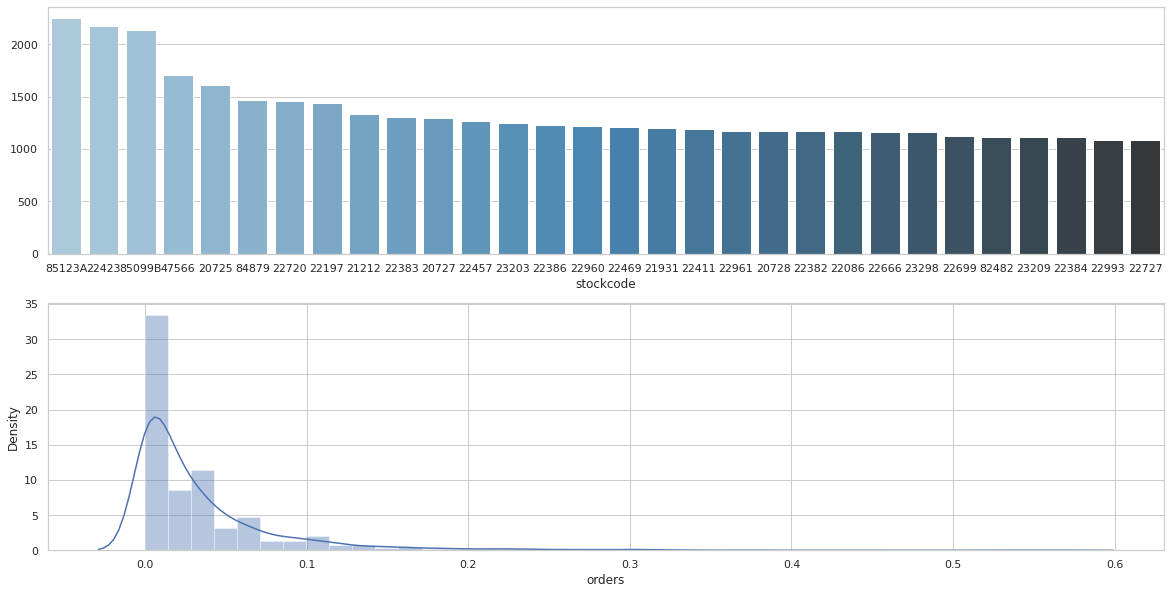

In [ ]:
dfp = df.groupby('stockcode').agg({
    'total_price': 'sum',
    'quantity': 'sum',
    'customer_id': 'nunique',
    'invoice_no': 'nunique',
})
dfp.columns = ['revenue', 'quantity', 'customers', 'orders'] #22423
dfp.sort_values(by='orders', inplace=True, ascending=False)

# Best selling products
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10))
sns.barplot(
    dfp.orders.iloc[:30].index,
    dfp.orders.iloc[:30].values,
    ax=ax1, 
    palette="Blues_d"
)

# Distribution of product sales
sns.distplot(
    round((dfp.orders/dfp.shape[0]), 2),
    kde=True,
    bins=40,
    ax=ax2, 
    color="b"
)

**Most Cancelled Products**



In [ ]:
df_can_items = df[df.is_cancel].groupby('stockcode', as_index=False).agg({
    'invoice_no': 'nunique',
    # 'quantity': 'sum',
    # 'total_price': 'sum',
})
df_can_items.columns = ['stockcode', 'can_orders']
df_can_items['orders'] = df_can_items.stockcode.apply(lambda x: dfp.loc[x].orders)
df_can_items['proportion'] = df_can_items['can_orders'] / df_can_items['orders']
df_can_items.sort_values(by='proportion', ascending=True, inplace=True)

df_can_items

,stockcode,can_orders,orders,proportion
156,21213,1,664.0,0.001506
411,21935,1,531.0,0.001883
436,22029,1,528.0,0.001894
1787,84596B,1,523.0,0.001912
111,21080,2,988.0,0.002024
...,...,...,...,...
1636,85063,2,2.0,1.000000
1836,85023C,1,1.0,1.000000
292,21645,1,1.0,1.000000
1516,37503,1,1.0,1.000000


Most returned products with at least 20 unique orders

Returned product distribution

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


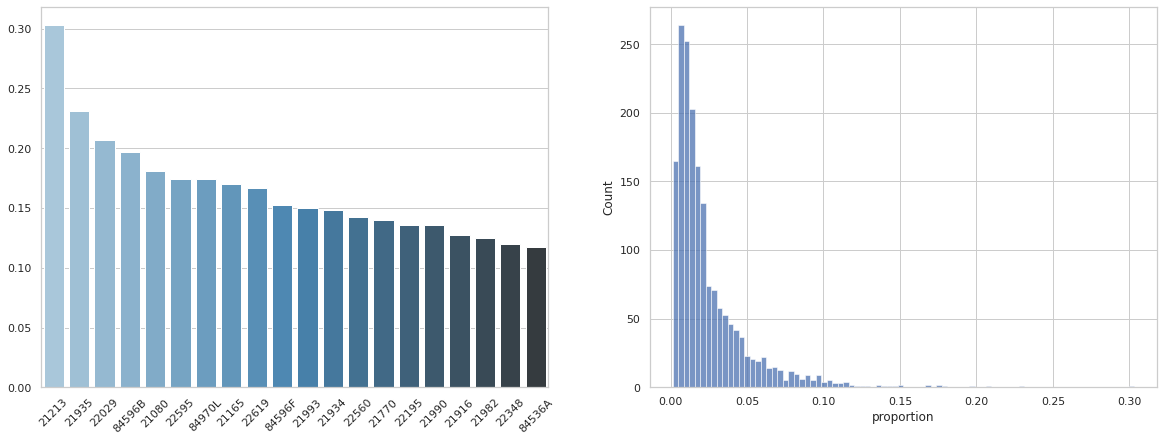

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

# Most cancelled products with at least 20 orders
tmp = df_can_items[df_can_items.orders > 20].sort_values(by='proportion', ascending=False)
sns.barplot(
    tmp.stockcode.iloc[:20].values,
    tmp.proportion.iloc[:20].values,
    palette='Blues_d',
    ax=ax1
)
ax1.set_xticklabels(df_can_items.stockcode.iloc[:20].values, rotation=45)

# Cancellation distribution
sns.histplot(
    data=tmp,
    x = 'proportion',
    color='b',
    ax=ax2
)

plt.show()

**Revenue**

In [ ]:
dfr_month = df.groupby('invoice_date_month').total_price.sum()
dfr_hour = df.groupby('invoice_date_hour').total_price.sum()
# dfr_country = df.groupby('country').total_price.sum().reset_index()

dfr_country = df.groupby('country').agg({
    'customer_id': ['nunique'],
    'invoice_no': ['nunique'],
    'total_price': ['sum'],
})

dfr_country.columns = ['customers','orders','revenue']
dfr_country['orders_per_customer'] = round(dfr_country.orders / dfr_country.customers,2)
dfr_country['average_order'] = round(dfr_country.revenue / dfr_country.orders,2)
dfr_country['revenue_proportion'] = dfr_country.revenue / dfr_country.revenue.sum()
dfr_country['customers_proportion'] = dfr_country.customers / dfr_country.customers.sum()

dfr_country.sort_values(by='customers', ascending=False, inplace=True)
dfr_country.head(10)

df.head(5)

,customer_id,invoice_no,is_cancel,stockcode,unit_price,quantity,total_price,country,invoice_date_year,invoice_date_month,invoice_date_day,invoice_date_hour,invoice_date_weekday,invoice_date
0,17850.0,536365,False,85123A,2.55,6,15.30,United Kingdom,2010,12,1,8,2,2010-12-01 08:26:00
1,17850.0,536365,False,71053,3.39,6,20.34,United Kingdom,2010,12,1,8,2,2010-12-01 08:26:00
2,17850.0,536365,False,84406B,2.75,8,22.00,United Kingdom,2010,12,1,8,2,2010-12-01 08:26:00
3,17850.0,536365,False,84029G,3.39,6,20.34,United Kingdom,2010,12,1,8,2,2010-12-01 08:26:00
4,17850.0,536365,False,84029E,3.39,6,20.34,United Kingdom,2010,12,1,8,2,2010-12-01 08:26:00


Visualize revenue based on time

Visualize number of customers based on time

[Text(0, 0.5, ''), Text(0.5, 0, '')]

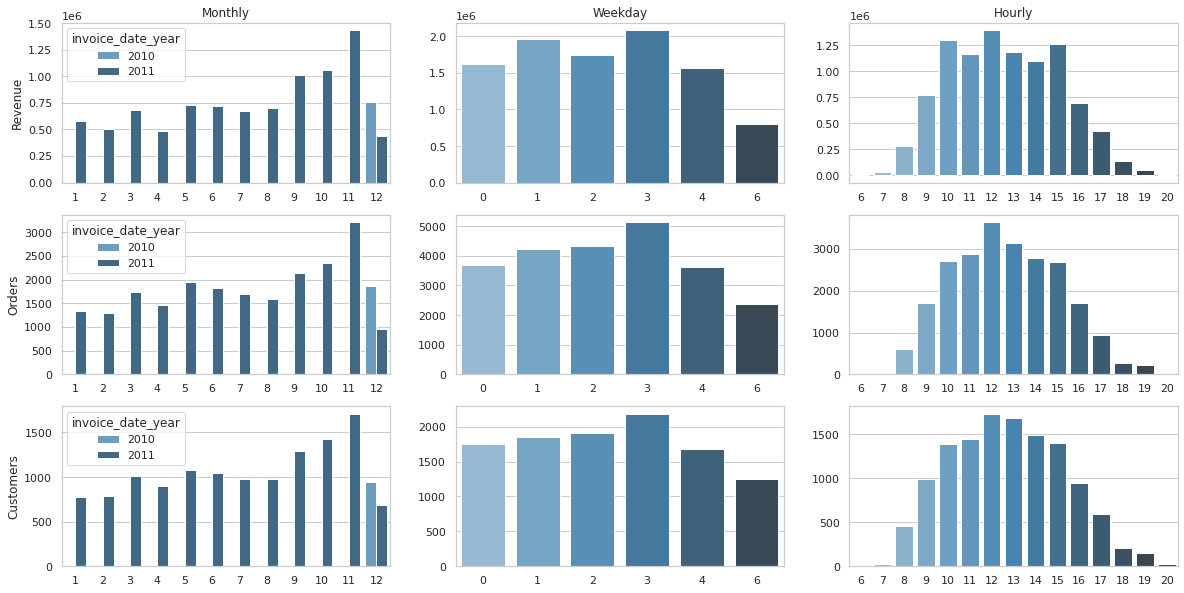

In [ ]:
dfr_month = df.groupby(['invoice_date_year','invoice_date_month']).agg({
  'total_price': 'sum',
  'invoice_no': 'nunique',
  'customer_id': 'nunique'
}).reset_index()

dfr_weekday = df.groupby('invoice_date_weekday').agg({
  'total_price': 'sum',
  'invoice_no': 'nunique',
  'customer_id': 'nunique'
}).reset_index()

dfr_hour = df.groupby('invoice_date_hour').agg({
  'total_price': 'sum',
  'invoice_no': 'nunique',
  'customer_id': 'nunique'
}).reset_index()


dfr_month.columns = ['invoice_date_year', 'invoice_date_month', 'revenue', 'orders', 'customers']
dfr_weekday.columns = ['invoice_date_weekday', 'revenue', 'orders', 'customers']
dfr_hour.columns = ['invoice_date_hour', 'revenue', 'orders', 'customers']

fig, axes = plt.subplots(3,3, figsize=(20,10))
# ROW 1
# Revenue by month
sns.barplot(
    ax=axes[0,0],
    x='invoice_date_month', 
    y='revenue', 
    hue='invoice_date_year', 
    data=dfr_month,
    palette="Blues_d",
)
axes[0,0].set(xlabel='', ylabel='Revenue', title='Monthly')

# Revenue by weekday
sns.barplot(
    ax=axes[0,1],
    x='invoice_date_weekday', 
    y='revenue', 
    data=dfr_weekday,
    palette="Blues_d",
)
axes[0,1].set(xlabel='', ylabel='', title='Weekday')

# Revenue by hour
sns.barplot(
    ax=axes[0,2],
    x='invoice_date_hour', 
    y='revenue', 
    data=dfr_hour,
    palette="Blues_d",
)
axes[0,2].set(xlabel='', ylabel='', title='Hourly')

# ROW 2
# Orders by month
sns.barplot(
    ax=axes[1,0],
    x='invoice_date_month', 
    y='orders', 
    hue='invoice_date_year', 
    data=dfr_month,
    palette="Blues_d",
)
axes[1,0].set(xlabel='', ylabel='Orders')

# Orders by weekday
sns.barplot(
    ax=axes[1,1],
    x='invoice_date_weekday', 
    y='orders', 
    data=dfr_weekday,
    palette="Blues_d",
)
axes[1,1].set(xlabel='', ylabel='')

# Orders by hour
sns.barplot(
    ax=axes[1,2],
    x='invoice_date_hour', 
    y='orders', 
    data=dfr_hour,
    palette="Blues_d",
)
axes[1,2].set(xlabel='', ylabel='')

# ROW 3
# Customers by month
sns.barplot(
    ax=axes[2,0],
    x='invoice_date_month', 
    y='customers', 
    hue='invoice_date_year', 
    data=dfr_month,
    palette="Blues_d",
)
axes[2,0].set(xlabel='', ylabel='Customers')

# Customers by weekday
sns.barplot(
    ax=axes[2,1],
    x='invoice_date_weekday', 
    y='customers', 
    data=dfr_weekday,
    palette="Blues_d",
)
axes[2,1].set(xlabel='', ylabel='')

# Customers by hour
sns.barplot(
    ax=axes[2,2],
    x='invoice_date_hour', 
    y='customers', 
    data=dfr_hour,
    palette="Blues_d",
)
axes[2,2].set(xlabel='', ylabel='')

**Customers**

In [ ]:
dfc = df.groupby('customer_id').agg({
    'invoice_no': ['nunique'],
    'total_price': ['sum'],
    'country': lambda x: x.unique()[0]
})

dfc.columns = ['orders','total_revenue','country']
dfc.sort_values(by='total_revenue', ascending=False, inplace=True)
dfc['is_uk'] = dfc.country.apply(lambda x: x == 'United Kingdom') 

dfc.head()

,orders,total_revenue,country,is_uk
customer_id,,,,
14646.0,74,278778.02,Netherlands,False
18102.0,60,259657.30,United Kingdom,True
17450.0,49,189735.53,United Kingdom,True
14911.0,243,132775.08,EIRE,False
12415.0,24,123638.18,Australia,False


# **RFM model**
Customer segmentation

In [ ]:
last_order_date = df.invoice_date.max()

# Group customers and generate Recency, Frequency and Monetary value
df_rfm = df.groupby('customer_id').agg({
    'invoice_date': lambda x: (last_order_date - x.max()).days,
    'invoice_no': 'count',
    'total_price': 'sum'
})
df_rfm.columns = ['recency', 'frequency','monetary_value']

# Generate R, F, M values from quartiles 
labels = [1,2,3,4]
r_percentiles = pd.qcut(df_rfm.recency, q=len(labels), labels=labels[::-1])
f_percentiles = pd.qcut(df_rfm.frequency, q=len(labels), labels=labels)
m_percentiles = pd.qcut(df_rfm.monetary_value, q=len(labels), labels=labels)

df_rfm = df_rfm.assign(r=r_percentiles, f=f_percentiles, m=m_percentiles)
df_rfm['score'] = df_rfm[['r','f','m']].sum(axis=1)

# Describe score categories 
df_rfm.groupby('score').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': 'mean',
    'r': 'count'
}).round()

df_rfm.head()

,recency,frequency,monetary_value,r,f,m,score
customer_id,,,,,,,
12346.0,325,2,0.00,1,1,1,3
12347.0,1,182,4310.00,4,4,4,12
12348.0,74,27,1437.24,2,2,3,7
12349.0,18,72,1457.55,3,3,3,9
12350.0,309,16,294.40,1,1,2,4


Get optimal number of clusters

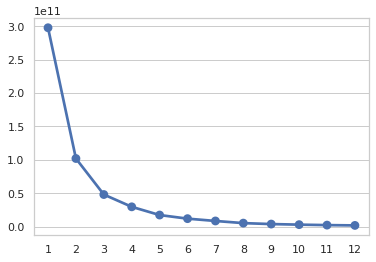

In [ ]:
error = []
for k in range(0,12):
  k_means = cluster.KMeans(n_clusters=k+1, random_state=0).fit(df_rfm.iloc[:,:-4])
  error.append(k_means.inertia_)

sns.pointplot(x=list(range(1,13)), y=error)
plt.show()

K-Means clustering

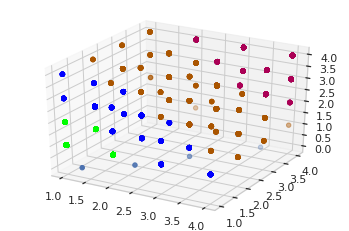

In [ ]:
from sklearn.cluster import KMeans

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df_rfm_std = pd.DataFrame(scaler.fit_transform(df_rfm))

model = KMeans(n_clusters=4, random_state=0).fit(df_rfm.iloc[:,3:])
centers = model.cluster_centers_

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    df_rfm.iloc[:,3],
    df_rfm.iloc[:,4],
    df_rfm.iloc[:,5],
    c=model.predict(df_rfm.iloc[:, 3:]),
    cmap='brg'
)

ax.scatter(
    centers[:,0], 
    centers[:,1], 
    c='b'
)


In [ ]:
df_rfm['cluster'] = model.labels_

df_rfm.groupby('cluster').agg({
    'recency': ['mean', 'min', 'max'],
    'frequency': ['mean', 'min', 'max'],
    'monetary_value': ['mean', 'min', 'max', 'count'],
})


recency           ... monetary_value                 
               mean min  max  ...            min        max count
cluster                       ...                                
0        123.786735   0  373  ...  -4.649000e+02   39619.50   980
1         18.121094   0  139  ...   3.018400e+02  278778.02  1280
2         62.038607   0  368  ...   2.664535e-14   12393.70  1321
3        218.988491  50  373  ...  -1.192200e+03     635.10   782

[4 rows x 10 columns]

0 - Potentially Lost Customer

1 - Best Customer

highest spend, lowest recency


2 - Lost Customer


3 - Good Customer





In [ ]:


# Orders/cancelations ratio by country
# Most cancelled products
# What countries cancel the most? Maybe a process mistake?

# correlation matrix country_revenue x month_revenue --> find best times?
# - encourage sales and deals on best performing months

# How long it takes for returning customer between orders?
# - average recency value?

# Is there increasing quantity on next orders?
# Similarity of orders on next orders?
# - how many of people who buy 2 will buy for 3 time?
# - how many people who both X will buy it again?